In [68]:
import numpy as np
import pandas as pd
import yfinance as yf 
import talib as ta
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [69]:
# Download the S&P 500 data
sp500 = yf.Ticker("^GSPC").history(period="max")

In [70]:
# Create RSI and MACD features
sp500['RSI'] = ta.RSI(sp500['Close'])
macd, macdsignal, macdhist = ta.MACD(sp500['Close'])
sp500['MACD'] = macd
sp500['MACDsignal'] = macdsignal
sp500['MACDhist'] = macdhist

In [71]:
# Drop NaN values
sp500 = sp500.dropna()

In [72]:
# Create the target variable
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.dropna()  # drop the last row as it has a NaN "Tomorrow" value

In [73]:
# Split the data into train, validation, and test sets # <-- New code here
train_data, temp_data = train_test_split(sp500, test_size=0.2, random_state=1)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

In [74]:
# Define predictors
predictors = ["Close", "Volume", "Open", "High", "Low", "RSI", "MACD", "MACDsignal", "MACDhist"]

In [75]:
# Create a pipeline for data preprocessing and modeling # <-- New code here
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

In [76]:
# Perform hyperparameter tuning with RandomizedSearchCV on the training set # <-- New code here
param_distributions = {
    'randomforestclassifier__n_estimators': np.arange(100, 500, 50),
    'randomforestclassifier__min_samples_split': np.arange(2, 50, 5),
    'randomforestclassifier__max_depth': np.arange(3, 10, 1),
}
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, scoring=make_scorer(f1_score), cv=3, random_state=1)
random_search.fit(train_data[predictors], train_data["Target"])
best_model = random_search.best_estimator_

In [77]:
# Evaluate the best model on the validation set
val_preds = best_model.predict(val_data[predictors])
print(f1_score(val_data["Target"], val_preds))

0.6652593486127866


In [78]:
# Perform cross-validation on the training set # <-- New code here
scores = cross_val_score(best_model, train_data[predictors], train_data["Target"], cv=5, scoring='f1')
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.67159603 0.6473223  0.66885845 0.65234746 0.66418189]
Mean cross-validation score:  0.6608612252627288


In [79]:
# Make final predictions on the test set and evaluate
test_preds = best_model.predict(test_data[predictors])
test_data['Action'] = ['Buy' if x==1 else 'Not to Buy' for x in test_preds]
print(f1_score(test_data["Target"], test_preds))

0.6565533980582525


In [80]:
# Creating a new DataFrame with actual and predicted values
test_results = test_data[["Target"]].copy()
test_results["Predicted"] = test_preds

In [81]:
# Create an interactive figure
fig = go.Figure()

# Add actual and predicted lines to the figure
fig.add_trace(go.Scatter(x=test_results.index, y=test_results['Target'], mode='markers', name='Actual'))
fig.add_trace(go.Scatter(x=test_results.index, y=test_results['Predicted'], mode='markers', name='Predicted'))

# Set the title and labels
fig.update_layout(title='Actual vs Predicted on Test Set',
                  xaxis_title='Date',  
                  yaxis_title='Target')   


In [82]:
test_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,MACD,MACDsignal,MACDhist,Tomorrow,Target,Action
Date,,,,,,,,,,,,,,
1993-08-10 00:00:00-04:00,450.709991,450.709991,449.100006,449.450012,255520000,0.0,0.0,52.909525,0.585190,0.433603,0.151587,450.459991,1,Buy
1960-03-25 00:00:00-05:00,55.980000,55.980000,55.980000,55.980000,2640000,0.0,0.0,59.084412,-0.019794,-0.264226,0.244431,55.860001,0,Buy
1951-12-19 00:00:00-05:00,23.570000,23.570000,23.570000,23.570000,1510000,0.0,0.0,67.070710,0.159989,0.104671,0.055318,23.570000,0,Buy
1947-12-30 00:00:00-05:00,15.220000,15.220000,15.220000,15.220000,0,0.0,0.0,54.905900,0.005649,-0.025355,0.031004,15.300000,1,Buy
1938-05-11 00:00:00-04:00,10.490000,10.490000,10.490000,10.490000,0,0.0,0.0,57.815932,0.109064,0.033777,0.075287,10.430000,0,Not to Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938-09-14 00:00:00-04:00,11.300000,11.300000,11.300000,11.300000,0,0.0,0.0,34.527735,-0.125556,-0.020899,-0.104657,11.670000,1,Not to Buy
1953-04-02 00:00:00-05:00,25.230000,25.230000,25.230000,25.230000,1720000,0.0,0.0,28.880503,-0.144476,-0.034385,-0.110091,24.610001,0,Buy
1988-05-18 00:00:00-04:00,255.399994,255.669998,250.729996,251.350006,209420000,0.0,0.0,36.368096,-2.137963,-1.617992,-0.519971,252.570007,1,Buy


In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
# Calculate confusion matrix
cf_matrix = confusion_matrix(test_data["Target"], test_preds)

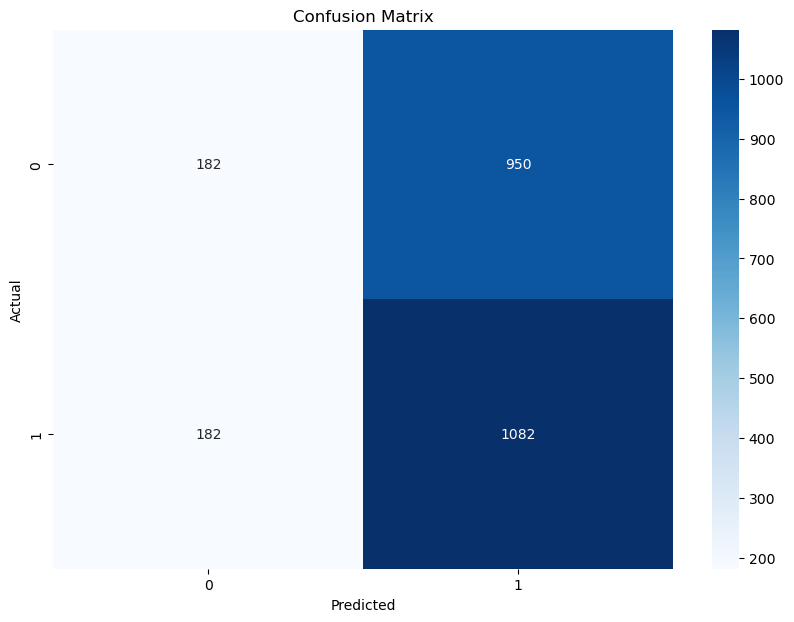

In [85]:
# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [86]:
# Add "Buy" or "Not to buy" column
test_data['Action'] = ['Buy' if x == 1 else 'Not to buy' for x in test_preds]

In [87]:
# Create a new DataFrame with actual and predicted values
test_results = test_data[["Action"]].copy()
test_results["Predicted"] = ['Buy' if x == 1 else 'Not to buy' for x in test_preds]

In [88]:
# Create an interactive figure
fig = go.Figure()

# Add actual and predicted lines to the figure
fig.add_trace(go.Scatter(x=test_results.index, y=test_results['Action'], mode='markers', name='Actual'))
fig.add_trace(go.Scatter(x=test_results.index, y=test_results['Predicted'], mode='markers', name='Predicted'))

# Set the title and labels
fig.update_layout(title='Actual vs Predicted Actions on Test Set',
                  xaxis_title='Date',  
                  yaxis_title='Action') 

# Show the figure
fig.show()

In [89]:
# Create a new DataFrame with actual and predicted values
test_results = test_data[["Action", "Close"]].copy()
test_results["Predicted_Action"] = ['Buy' if x == 1 else 'Not to buy' for x in test_preds]

# Create an interactive figure
fig = go.Figure()

# Add the stock closing values line to the figure
fig.add_trace(go.Scatter(x=test_results.index, 
                         y=test_results['Close'], 
                         mode='markers', 
                         name='Close Price'))

# Add actual and predicted actions to the figure
fig.add_trace(go.Scatter(x=test_results.index, 
                         y=test_results['Action'], 
                         mode='lines', 
                         name='Actual Action'))
fig.add_trace(go.Scatter(x=test_results.index, 
                         y=test_results['Predicted_Action'], 
                         mode='lines', 
                         name='Predicted Action'))

# Set the title and labels
fig.update_layout(title='Actual vs Predicted Actions and Close Prices on Test Set',
                  xaxis_title='Date',  
                  yaxis_title='Action / Close Price') 

# Show the figure
fig.show()

In [92]:
fig = make_subplots(rows=2, cols=1)

# Add closing price as a bar to the figure
fig.add_trace(go.Bar(x=test_results.index, y=test_results['Close'], name='Close Price', marker_color='Darkblue'), row=1, col=1)

# Add actual and predicted actions dots to the figure
fig.add_trace(go.Scatter(x=test_results.index, y=test_results['Action'], name='Actual Action', mode='markers', marker=dict(size=10, color='red')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_results.index, y=test_results["Predicted_Action"], name='Predicted Action', mode='markers', marker=dict(size=10, color='yellow', opacity=0.1)), row=2, col=1)

# Set the title and labels
fig.update_layout(height=600, width=800, title_text="Close Price and Actual vs Predicted Actions", 
                  title_x=0.5, plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', font_color='Black')
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Close Price", row=1, col=1)
fig.update_yaxes(title_text="Action (Buy=1, Not Buy=0)", row=2, col=1)

# Show the figure
fig.show()
